# Introduction

In this dataset, we are provided with the absentee records of employees in a small courier company in Brazil over the period of Jul 2007 - Jul 2010.

With this dataset, I will attempt to discover any trends, interesting nuggets of information and factors that influence absenteeism in this particular company.

<b>Disclaimer:</b> Please note that the outcomes of the analyses performed on this dataset is specific to it and may not reflect or is applicable to real-life situations.

<hr>

In [32]:
# Initialization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels

sns.set_style('ticks')
plt.rc("axes.spines", top=False, right=False)
pd.options.display.max_columns = None
pd.options.display.float_format = "{:.1f}".format

In [2]:
# Load the dataset
df = pd.read_csv('Dataset\Absenteeism_at_work.csv', delimiter=';')

# Correcting an erroneous entry in row 51
# 'ID' erroneously set to 29 instead of 28; for evidence, compare with values in rows 52 and 592
df.loc[51,'ID'] = 28

df.head()

,ID,Reason for absence,Month of absence,Day of the week,Seasons,Transportation expense,Distance from Residence to Work,Service time,Age,Work load Average/day,Hit target,Disciplinary failure,Education,Son,Social drinker,Social smoker,Pet,Weight,Height,Body mass index,Absenteeism time in hours
0,11,26,7,3,1,289,36,13,33,239.6,97,0,1,2,1,0,1,90,172,30,4
1,36,0,7,3,1,118,13,18,50,239.6,97,1,1,1,1,0,0,98,178,31,0
2,3,23,7,4,1,179,51,18,38,239.6,97,0,1,0,1,0,0,89,170,31,2
3,7,7,7,5,1,279,5,14,39,239.6,97,0,1,2,1,1,0,68,168,24,4
4,11,23,7,5,1,289,36,13,33,239.6,97,0,1,2,1,0,1,90,172,30,2


<hr>

# 1: What are the top 5 reasons that employees are taking the day off for?


In [3]:
# Absences are coded based on the International Code of Diseases (ICD) for categories 1 to 21.
# An additional 7 categories that are not on the ICD are included (categories 22-28).

# Dict for the categories in 'Reason for absence' column in df
icd_dict = {0:'Unspecified', 
            1:'Certain infectious and parasitic diseases',
            2:'Neoplasms',
            3:'Diseases of the blood and blood-forming organs and certain disorders involving the immune mechanism',
            4:'Endocrine, nutritional and metabolic diseases',
            5:'Mental and behavioural disorders',
            6:'Diseases of the nervous system',
            7:'Diseases of the eye and adnexa',
            8:'Diseases of the ear and mastoid process',
            9:'Diseases of the circulatory system',
            10:'Diseases of the respiratory system',
            11:'Diseases of the digestive system',
            12:'Diseases of the skin and subcutaneous tissue',
            13:'Diseases of the musculoskeletal\nsystem and connective tissue',
            14:'Diseases of the genitourinary system',
            15:'Pregnancy, childbirth and the puerperium',
            16:'Certain conditions originating\nin the perinatal period',
            17:'Congenital malformations, deformations\nand chromosomal abnormalities',
            18:'Symptoms, signs and abnormal clinical and\nlaboratory findings, not elsewhere classified',
            19:'Injury, poisoning and certain other\nconsequences of external causes',
            20:'External causes of morbidity and mortality',
            21:'Factors influencing health status and\ncontact with health services.',
            22:'Patient follow-up',
            23:'Medical consultation',
            24:'Blood donation',
            25:'Laboratory examination',
            26:'Unjustified absence',
            27:'Physiotherapy',
            28:'Dental consultation'}

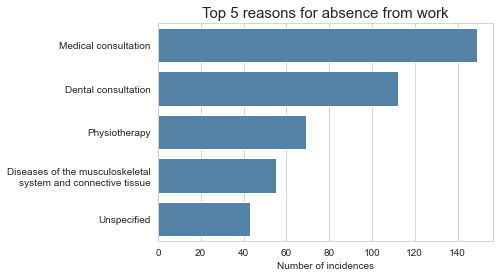

In [4]:
# Replace numerical values with categorical labels
df_reason = df['Reason for absence'].replace(icd_dict)

# Top 5 reasons for absence
top5_reason = df_reason.value_counts().head()

with sns.axes_style('whitegrid'):
    sns.barplot(y=top5_reason.index, x=top5_reason, color='steelblue', ci=None)
plt.title('Top 5 reasons for absence from work', fontdict={'fontsize':15})
plt.xlabel('Number of incidences')
plt.show()


### Medical and dental consultations rank top among the reasons for absences in the period between Jul 2007 to Jul 2010. Not surprisingly, physiotherapy and diseases of the musculoskeletal system/connective tissue rank high at 3<sup>rd</sup> and 4<sup>th</sup> respectively! 

### Working in a courier service is a physically demanding job and injuries involving the neck, back and upper extremities are the among the most frequent.<sup>1,2</sup>
<br>
1. Smith CK, Williams J. Work related injuries in Washington State's Trucking Industry, by industry sector and occupation. Accident Analysis & Prevention. 2014 Apr 1;65:63-71.<br>
2. Dennerlein JT, Meeker JD. Occupational injuries among Boston bicycle messengers. American journal of industrial medicine. 2002 Dec;42(6):519-25.
<br>
<br>

# 2.1: Are there any seasonal trend for absences?

In [5]:
# Data integrity check of month of absence vs seasons 
season_check = df.drop_duplicates(subset=['Month of absence','Seasons'])
season_check = season_check[['Month of absence','Seasons']].sort_values(by=['Month of absence','Seasons'])

# Drop where month of absence == 0, since it is not specified
season_check[season_check['Month of absence'] > 0]

,Month of absence,Seasons
113,1,2
137,2,2
155,3,2
175,3,3
184,4,3
204,5,3
234,6,1
220,6,3
0,7,1
19,8,1


### According to https://seasonsyear.com/Brazil, <br>- Spring months = 9, 10, 11<br>- Summer months = 12, 1, 2<br>- Autumn months = 3, 4, 5<br>- Winter months = 6, 7, 8

### Some months exist in 2 seasons(i.e. month 3 is in season 2 & 3), which I assume is because the change in season falls somewhere in the middle of the month.

### Going by the seasonal months listed on the website and allowing for some leeway in the overlap of seasons, the seasons and their corresponding numbers are decided as such:

In [6]:
season_dict = {1:'Winter',
               2:'Summer',
               3:'Autumn',
               4:'Spring'}

season_mths = {1:'Summer',
               2:'Summer',
               3:'Autumn',
               4:'Autumn',
               5:'Autumn',
               6:'Winter',
               7:'Winter',
               8:'Winter',
               9:'Spring',
               10:'Spring',
               11:'Spring',
               12:'Summer'}

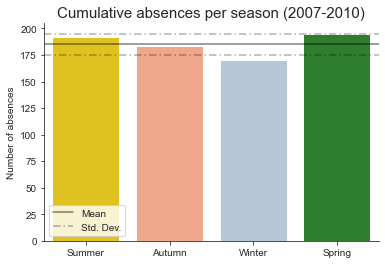

In [7]:
# Calculating the number of absences per season

abs_season = df.groupby(df['Seasons']).size()
abs_season = abs_season.reset_index().rename(columns={0:'Number of absences'})
abs_season['Seasons'].replace(season_dict, inplace=True)

# Calculating the mean and standard deviation of the seasonal absences
mean_abs_sea = float(abs_season.mean())
sd_abs_sea = float(np.std(abs_season))

# Plotting figure
sea_labels = ['Summer','Autumn','Winter','Spring']
colors = sns.color_palette(['gold','lightsalmon','lightsteelblue','forestgreen'])

seaPlot = sns.barplot(x='Seasons', y='Number of absences', data=abs_season, order=sea_labels, palette=colors)
seaPlot.axhline(mean_abs_sea, color='black', alpha=0.5, label='Mean')
seaPlot.axhline(mean_abs_sea + sd_abs_sea, color='black', alpha=0.3, dashes=(5,2,1,2), label= 'Std. Dev.')
seaPlot.axhline(mean_abs_sea - sd_abs_sea, color='black', alpha=0.3, dashes=(5,2,1,2))
plt.legend()
plt.xlabel('')
plt.title('Cumulative absences per season (2007-2010)', fontdict={'fontsize':15})
plt.show()

### It does not seem like there are much differences in absences between seasons between 2007-2010. How about the months?

# 2.2: Are there any monthly trend for absences?

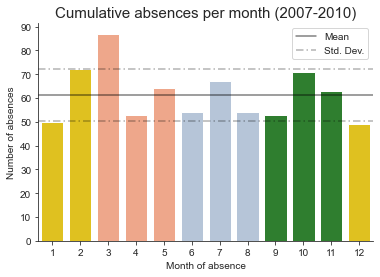

In [8]:
# Calculating the number of absences per month
abs_mth = df.groupby(df['Month of absence']).size()

# Dropping index 0 from 'Month of absence' as it was not specified
abs_mth = abs_mth.drop(0)

# Reconverting it back into dataframe and renaming the count column as 'Count'
# Months are also linked to seasons for plotting
abs_mth = abs_mth.reset_index().rename(columns={0:'Number of absences'})
abs_mth['Seasons'] = abs_mth['Month of absence'].map(season_mths)

# Calculating the mean and standard deviation of the monthly absences
mean_abs_mth = abs_mth.mean()[1]
sd_abs_mth = np.std(abs_mth)[1]

# Color map to group the months by seasons 
color_map = dict(zip(sea_labels, colors))

# Plotting figure and horizontal lines for mean and stdev
mthPlot = sns.barplot(x='Month of absence', y='Number of absences', data=abs_mth, palette=abs_mth['Seasons'].map(color_map))
mthPlot.axhline(mean_abs_mth, color='black', alpha=0.5, label='Mean')
mthPlot.axhline(mean_abs_mth+sd_abs_mth, color='black', alpha=0.3, dashes=(5,2,1,2), label= 'Std. Dev.')
mthPlot.axhline(mean_abs_mth-sd_abs_mth, color='black', alpha=0.3, dashes=(5,2,1,2))
plt.yticks(range(0, max(abs_mth['Number of absences'])+10, 10))
plt.legend()
plt.title('Cumulative absences per month (2007-2010)', fontdict={'fontsize':15})
plt.show()

### March stands out among the other months with the highest number of absences, well above the mean by approximately 42%! 

### Perhaps the celebrations (i.e. Carnival Rio de Janeiro, Good Friday & Easter Sunday) in February and March has taken a toll on the health of the employees? Or could there be a massive uptick in workload for this particular month? Unfortunately, there is not enough data granularity to explore this further.
<br>
'Events in March' - https://www.kimkim.com/c/brazil-in-march-travel-tips-weather-and-more
<br>

# 2.3: Which employee has taken the most number of absences in the month of March from 2007-2010?

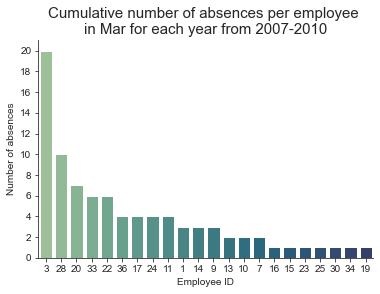

In [9]:
# Drilling down to the month of March
mar_df = df[df['Month of absence']==3]
mar_absentees = mar_df.groupby('ID').size().sort_values(ascending=False)

# Plot
sns.barplot(x=mar_absentees.index, y=mar_absentees.values, palette='crest', order=mar_absentees.index)
plt.yticks(range(0, max(mar_absentees.values)+1, 2))
plt.xlabel('Employee ID')
plt.ylabel('Number of absences')
plt.title('Cumulative number of absences per employee \nin Mar for each year from 2007-2010', fontdict={'fontsize':15})
plt.show()

### Employee #3 accounted for 20 out of 87 absences (23%) for the month of March from 2007 to 2010. What could be the reason behind this?
<br>
<br>

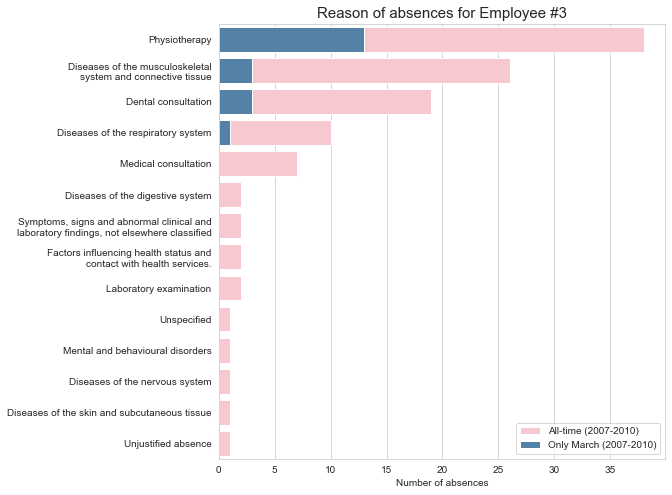

In [10]:
# Drilling down to employee 3 for all-time
id3_all = df[df['ID']==3].groupby('Reason for absence').size()
id3_all = id3_all.reset_index().rename(columns={0:'Number of absences'})
id3_all = id3_all.sort_values('Number of absences', ascending=False)
id3_all['Reason for absence'] = id3_all['Reason for absence'].replace(icd_dict)

# Drilling down to employee 3 for March
id3 = mar_df[mar_df['ID']==3].groupby('Reason for absence').size()
id3 = id3.reset_index().rename(columns={0:'Number of absences'})
id3 = id3.sort_values('Number of absences', ascending=False)
id3['Reason for absence'] = id3['Reason for absence'].replace(icd_dict)

# Summary of reasons for absence for all employees, all-time; uncomment lines 14 & 25 in this cell to see
# absence_all = df_reason.value_counts()

# Adding additional rows from id3_all that are not found in id3 to id3 so that the stacked bar plot can be plotted with all details
# Missing rows are set to 0 count
temp_df = id3_all.copy()
temp_df['Number of absences'] = 0
id3 = pd.concat([id3,temp_df]).drop_duplicates('Reason for absence', keep='first')

# Plotting March absences on top of all-time absences for employee ID 3 
with sns.axes_style('whitegrid'):
    ax = plt.subplots(figsize=(8,8))
# ax = sns.barplot(y=absence_all.index, x=absence_all, color='lightcoral', ci=None)
ax = sns.barplot(y='Reason for absence', x='Number of absences', data=id3_all, color='pink', label='All-time (2007-2010)')
ax = sns.barplot(y='Reason for absence', x='Number of absences', data=id3, color='steelblue',label='Only March (2007-2010)')

plt.ylabel('')
plt.legend()
plt.title('Reason of absences for Employee #3', fontdict={'fontsize':15})
plt.show()

### It looks like Employee #3 spent a lot of time undergoing physiotherapy and recuperating from their injuries. It would be prudent to have the employer or supervisor discuss and reassess their workload or scope to help minimize injuries.
<hr>

### Having analyzed Employee #3's history of absenteeism, I wanted to know more about the rest of the employees.

# 3: What do the demographics of the company's employees look like?

In [11]:
# Creating a new dataframe focused on each ID
col_to_extract = ['ID','Age','Service time','Distance from Residence to Work',
                  'Education', 'Son', 'Social drinker', 'Social smoker', 
                  'Pet', 'Weight', 'Height', 'Body mass index']

summ_df = df.groupby('ID').agg({
                'Absenteeism time in hours':'sum',
                'ID':'size'})
summ_df = summ_df.rename(columns={
                'Absenteeism time in hours':'Total absenteeism hours',
                'ID':'Total number of absences'}).reset_index()
summ_df = summ_df.merge(df[col_to_extract], on='ID', how='left')
summ_df = summ_df.drop_duplicates().reset_index(drop=True).rename(columns={
                'Son':'Number of children',
                'Pet':'Number of pets'})

summ_df.describe()

,ID,Total absenteeism hours,Total number of absences,Age,Service time,Distance from Residence to Work,Education,Number of children,Social drinker,Social smoker,Number of pets,Weight,Height,Body mass index
count,36.0,36.0,36.0,36.0,36.0,36.0,36.0,36.0,36.0,36.0,36.0,36.0,36.0,36.0
mean,18.5,142.3,20.6,38.3,12.4,27.2,1.4,1.1,0.5,0.2,1.3,78.9,173.1,26.4
std,10.5,148.5,23.8,7.9,5.3,14.5,0.8,1.0,0.5,0.4,2.1,13.6,6.3,4.7
min,1.0,0.0,1.0,27.0,1.0,5.0,1.0,0.0,0.0,0.0,0.0,56.0,163.0,19.0
25%,9.8,24.0,5.0,32.0,9.0,15.0,1.0,0.0,0.0,0.0,0.0,68.0,169.0,23.0
50%,18.5,78.0,9.0,37.5,13.0,25.5,1.0,1.0,1.0,0.0,0.0,76.5,172.0,25.0
75%,27.2,253.2,29.2,43.0,14.0,37.5,1.0,2.0,1.0,0.0,2.0,88.2,175.8,29.2
max,36.0,482.0,113.0,58.0,29.0,52.0,4.0,4.0,1.0,1.0,8.0,108.0,196.0,38.0


### Let's explore this visually.

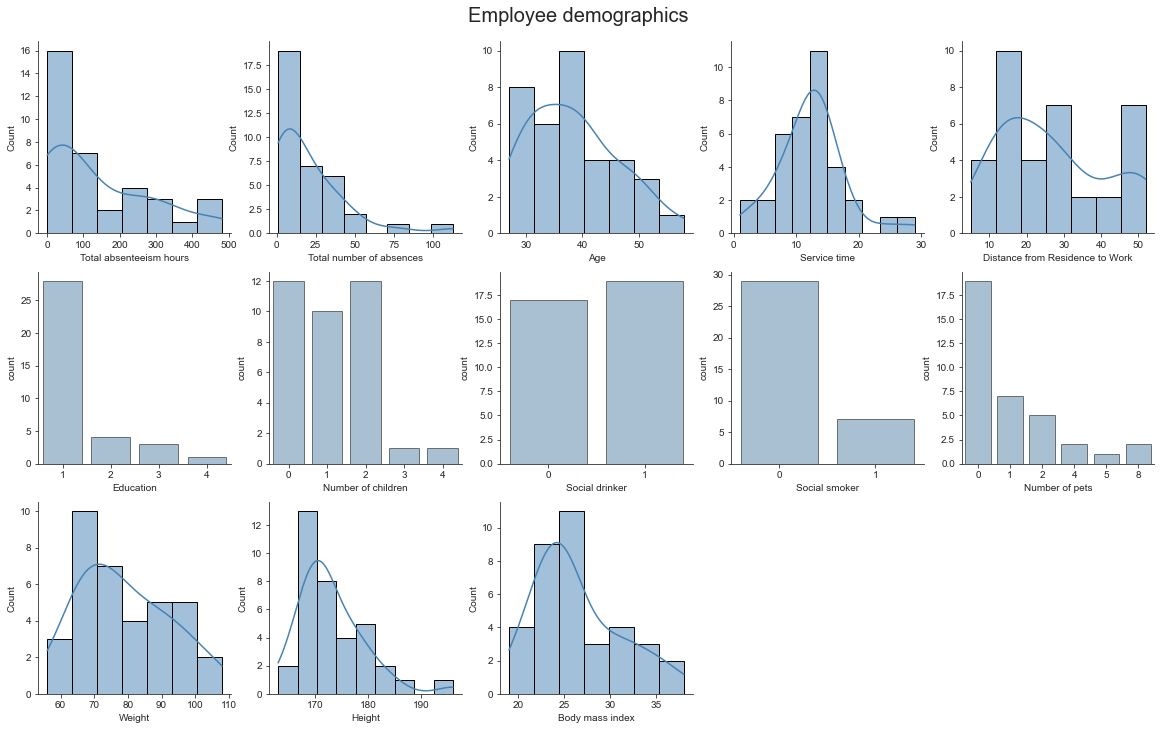

In [12]:
# 3 x 5 figure
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(20,12))

# Plot histograms for each column in summ_df; num = 1 to exclude 'ID' column
num = 1
for row in range(3):
    for col in range(5):
        if row == 2 and col == 3:
            break
        else:
            if 6 <= num <= 10:
                sns.countplot(x=summ_df.columns[num], data=summ_df, ax=axes[row,col],
                              color='steelblue', alpha=0.5, edgecolor='black', linewidth=1)
            else:
                sns.histplot(summ_df[summ_df.columns[num]], ax=axes[row,col], 
                         kde=True, color='steelblue', edgecolor='black')
            num += 1

plt.suptitle('Employee demographics', y= 0.92, size=20)

# Removing unused axes
fig.delaxes(ax=axes[2,3])
fig.delaxes(ax=axes[2,4])

plt.show()

\* Categorical codes

| Education                                            | Social drinker/smoker |
|------------------------------------------------------|-----------------------|
| (1) High school                                      | (0) No                |
| (2) Bachelor's degree                                | (1) Yes               |
| (3) Postgraduate (latu sensu)                        |                       |
| (4) Postgraduate (stricto sensu): Master's/Doctorate |                       |

### A 'median' employee in this company would be 37.5 years old, and has worked in the company for 13 years. They would have a high school diploma with 1 child and no pets in the household. Health-wise, they drink socially and do not smoke and has a BMI of 25. They live 25.5 km away from work and in the past 3 years, they would have 9 days of absences, totalling 78 workhours.

### In general, the company's employees tend to be younger than 40 years old and a majority are within the healthy range in BMI. Most employees have also been working there for more than 10 years, potentially indicating that they might be quite content with the company. Well done!

### As an animal lover, I would love to know more about the two employees with 8(!) pets in their household! How cool is that!

<hr>

# 4: Are there any correlations between demographics, lifestyle traits and absenteeism?

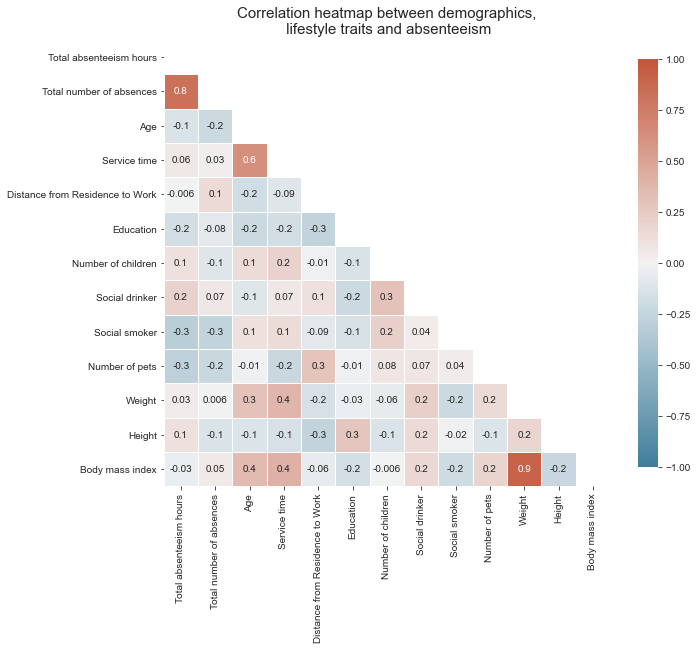

In [13]:
# Excluding ID from correlation calculations
corr = summ_df.iloc[:,1:].corr()

# Mask to remove the top symmetrical portion of the heatmap
mask = np.triu(corr)

# Plotting correlation heatmap
fig, ax = plt.subplots(figsize=(10,10))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr, cmap=cmap, mask=mask, vmax=1, vmin=-1, center=0, annot=True, fmt='.1g', 
            square=True, linewidths=0.5, cbar_kws={'shrink':0.75})
plt.title('Correlation heatmap between demographics,\n lifestyle traits and absenteeism',
          fontdict={'fontsize':15})
plt.show()

Might need to split the corr table up into 3.
- continuous vs continuous
- categorical vs continuous
- categorical vs categorical

https://towardsdatascience.com/the-search-for-categorical-correlation-a1cf7f1888c9

# WORK IN PROGRESS BELOW

### Neat! 

### There are some correlations in accordance with expectations, namely:
- Number of absences are positively correlated with total absenteeism hours.
- BMI being positively correlated with weight and negatively correlated with height.
    - BMI is calculated with $ \frac{weight (kg)} {height (m)^{2}} $
<br><br>

### A strong correlation (0.6) can also be found between service time and age, suggesting that the rate of employee turnover could be low within the company.
- The high positive correlation here implies that the older employees also tend to have a longer period of employment within the company. If employee turnover was high, we would expect to see the correlation coefficient closer to 0. 
<br><br>

### There are also some really interesting correlations that are of the moderate degree ($\pm$0.3 to $\pm$0.49):

|                       	| Variable 1            | Variable 2                        | Appropriate regression to use? |
|----------------------:	|--------------------	|---------------------------------	|------------------------------- |
| Negative correlations 	| Social smoker      	| Total number of absences        	| Binary logistic regression     |
|                       	| Number of pets     	| Total absenteeism hours         	| Nominal logistic regression    |
|                       	| Level of education 	| Distance from residence to work 	| Ordinal logistic regression    |
|                       	| Height             	| Distance from residence to work 	| Linear regression              |
|                       	|                    	|                                 	|                                |
| Positive correlations 	| Number of pets     	| Distance from residence to work 	| Nominal logistic regression    |
|                       	| Height             	| Education                       	| Ordinal logistic regression    |
|                       	| Social drinker     	| Number of children              	| Binary logistic regression     |

### Some are quite unexpected! For example, the employee height being positively correlated to education. But are these correlations valid? For these correlations, we will need to test for linearity and homoscedasticity. They can be assessed through the use of scatter plots and residual plots respectively.
<br><br>

\* Typically, these assumptions have to be tested on possible relationship pairs before calculating Pearson's correlation. However, this was now done post-hoc as the possible relationship pairs were too many. For more information: https://statistics.laerd.com/statistical-guides/pearson-correlation-coefficient-statistical-guide.php

 

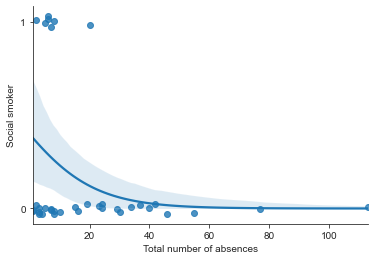

In [70]:

sns.regplot(x='Total number of absences', y='Social smoker', data=summ_df, logistic=True, y_jitter=0.03)
plt.yticks(range(2))
plt.show()

# https://www.statisticssolutions.com/free-resources/directory-of-statistical-analyses/assumptions-of-logistic-regression/

([<matplotlib.axis.YTick at 0x2392983a820>,
 [Text(0, 0, ''), Text(0, 0, '')])

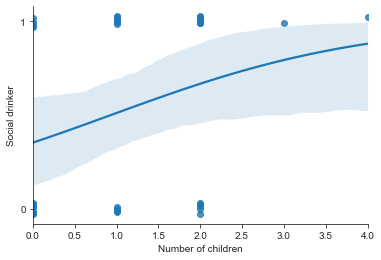

In [65]:
sns.regplot(x='Number of children', y='Social drinker', data=summ_df, logistic=True, y_jitter=0.03)
plt.yticks(range(2))

<AxesSubplot:xlabel='Number of pets', ylabel='Distance from Residence to Work'>

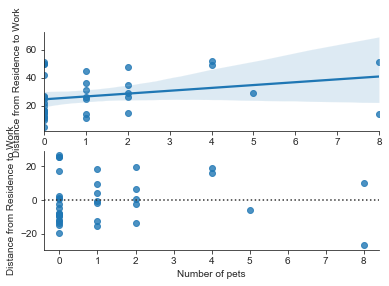

In [41]:
fig, (ax1, ax2) = plt.subplots(2)
sns.regplot(x='Number of pets', y='Distance from Residence to Work', data=summ_df, ax=ax1)
sns.residplot(x='Number of pets', y='Distance from Residence to Work', data=summ_df, ax=ax2)

In [14]:
# test a few of the interesting ones for linearity and homoscedasticity? 
# https://www.statisticssolutions.com/pearsons-correlation-coefficient/

# pairplot with residplot and scatterplot? <-- might be massive
# https://seaborn.pydata.org/generated/seaborn.PairGrid.html#seaborn.PairGrid

In [15]:
# Which age group are susceptible to absenteeism?
# Are there any relation to absences with BMI?
# What about social drinkers and smokers? Do they affect absenteeism?

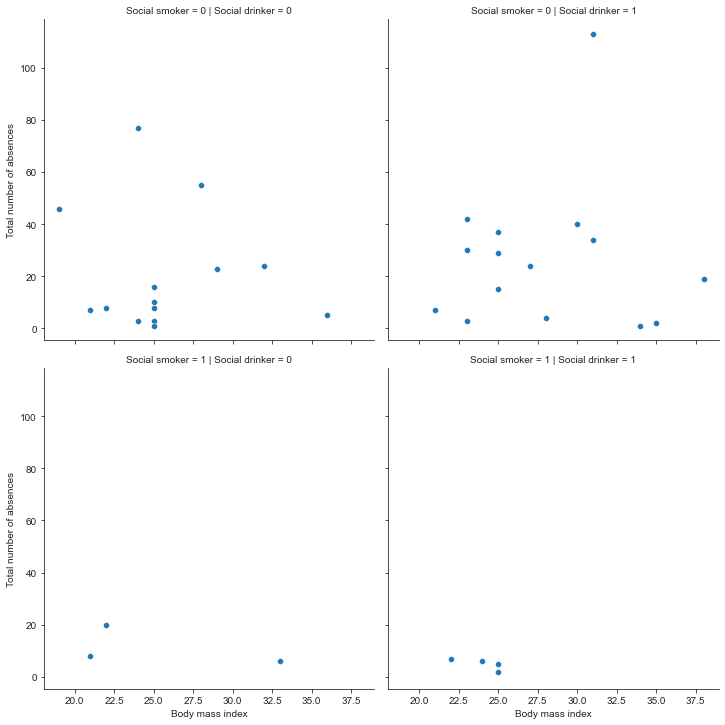

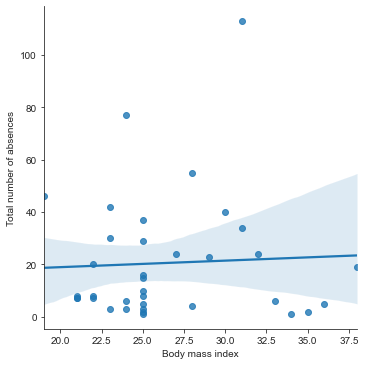

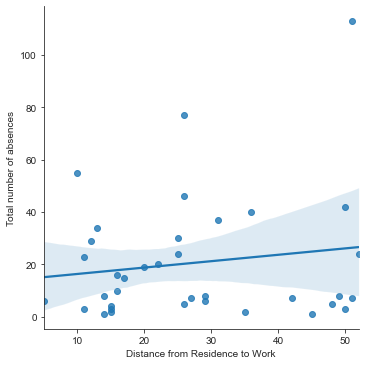

In [16]:
# sns.barplot(x='ID', y='Num of absences', data=summ_df)
sns.relplot(x='Body mass index', y='Total number of absences', col='Social drinker', row='Social smoker', data=summ_df)
sns.lmplot(x='Body mass index', y='Total number of absences', data=summ_df)
sns.lmplot(x='Distance from Residence to Work', y='Total number of absences', data=summ_df)
plt.show()

In [17]:
# TBC, looking at most commmon absentee reason for each employee

# for item, group in df[['ID','Reason for absence']].groupby(df['ID']):
#     print(item)
    # print(group)

df.groupby(['ID','Reason for absence']).size()

ID  Reason for absence
1   0                      1
    1                      1
    7                      1
    11                     1
    13                     3
                          ..
36  14                     2
    19                     2
    23                    11
    26                     1
    28                     4
Length: 250, dtype: int64